In [ ]:
import torch
import torch.multiprocessing
import torch.nn.functional as F
import numpy as np
import random
import os, sys, glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

sys.path.insert(0, os.path.abspath('..'))
from data import data_loader
from configs import datasets_config as config
import network.cb_net as net
from configs.params import *
from network import load_model
from torch.nn import functional as F
torch.multiprocessing.set_sharing_strategy('file_system')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(batch_size)
torch.cuda.manual_seed_all(batch_size)
np.random.seed(batch_size)
random.seed(batch_size)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.allow_tf32 = True

boiler_path = config.main_path['main'].replace('data', '')
method = 'cb_net'
if not os.path.exists(os.path.join('../graphs', 'pearson', method)):
    os.makedirs(os.path.join('../graphs', 'pearson', method))
    
emb_size = 512
load_model_path = '../models/cb_net/best_model/CB_Net.pth'
model = net.CB_Net(embedding_size = emb_size, do_prob=0.0).eval().to(device)
model = load_model.load_pretrained_network(model, load_model_path, device = device)

## Feature Extraction and Graph Plotting Functions

In [ ]:
def feature_extractor(model, data_loader, device='cuda:0', peri_flag=False):
    emb = torch.tensor([])
    lbl = torch.tensor([], dtype = torch.int16)

    model = model.eval().to(device)
    
    with torch.no_grad():        
        for batch_idx, (x, y) in enumerate(data_loader):
            x = x.to(device)
            x = model(x, peri_flag = peri_flag)

            emb = torch.cat((emb, x.detach().cpu()), 0)
            lbl = torch.cat((lbl, y))
            
            del x, y
    
    del data_loader, model
    
    return emb, lbl


def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
peri_gallery_dir = config.main_path['main'] + '/visualization/pearson/peri'
face_gallery_dir = config.main_path['main'] + '/visualization/pearson/face'
peri_gal_loader, peri_gal_set = data_loader.gen_data(peri_gallery_dir, 'test', type='peri')
face_gal_loader, face_gal_set = data_loader.gen_data(face_gallery_dir, 'test', type='face')

emb_peri, lbl_peri = feature_extractor(model, peri_gal_loader, device=device, peri_flag=True)
emb_face, lbl_face = feature_extractor(model, face_gal_loader, device=device, peri_flag=False)

In [4]:
emb_face_proto = torch.Tensor([])
emb_peri_proto = torch.Tensor([])
lbl_face_proto = torch.Tensor([])
lbl_peri_proto = torch.Tensor([])

for i in torch.unique(lbl_peri):
    # append unique labels to tensor list
    lbl_peri_proto = torch.cat((lbl_peri_proto, torch.tensor([i], dtype=torch.int64)))

    # get index list where unique labels occur
    indices = np.where(lbl_peri == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, emb_peri[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    emb_peri_proto = torch.cat((emb_peri_proto, proto_mean.detach().cpu()), 0)

for i in torch.unique(lbl_face):
    # append unique labels to tensor list
    lbl_face_proto = torch.cat((lbl_face_proto, torch.tensor([i], dtype=torch.int64)))

    # get index list where unique labels occur
    indices = np.where(lbl_face == i)
    feats = torch.tensor([])

    # from index list, append features into temporary face_feats list
    for j in indices:
        feats = torch.cat((feats, emb_face[j].detach().cpu()), 0)
    proto_mean = torch.unsqueeze(torch.mean(feats, 0), 0)
    proto_mean = F.normalize(proto_mean, p=2, dim=1)
    emb_face_proto = torch.cat((emb_face_proto, proto_mean.detach().cpu()), 0)

## Draw Graph

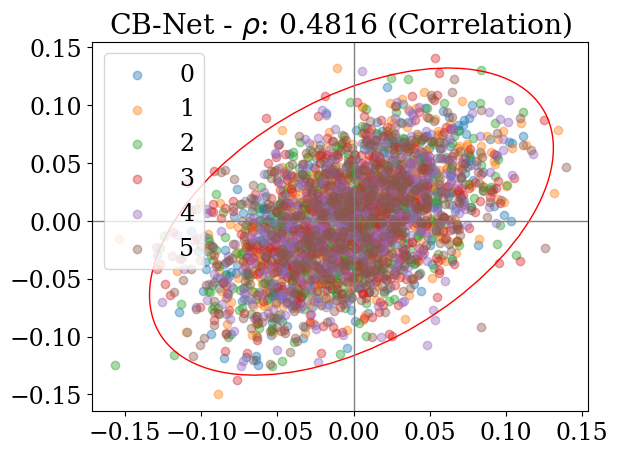

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 17, 'legend.fontsize': 17})    

fig, axs = plt.subplots(1, 1)
for i in range(lbl_face_proto.shape[0]):
    x, y = (F.normalize(emb_face_proto[i], p=2, dim=0)).numpy(), (F.normalize(emb_peri_proto[i], p=2, dim=0)).numpy()
    axs.scatter(x, y, alpha=0.4, label = str(lbl_face_proto[i].numpy().astype(int))) 
    # axs.axes.get_yaxis().set_visible(False)
    # axs.axes.get_xaxis().set_visible(False)
    # axs.spines['top'].set_visible(False)
    # axs.spines['right'].set_visible(False)
    # axs.spines['bottom'].set_visible(False)
    # axs.spines['left'].set_visible(False)
axs.axvline(c='grey', lw=1)
axs.axhline(c='grey', lw=1)
confidence_ellipse(x, y, axs, edgecolor='red')
plt.legend()
hist_cmp = cv2.compareHist(emb_face_proto.numpy(), emb_peri_proto.numpy(), cv2.HISTCMP_CORREL)
plt.title('CB-Net - $\\rho$: ' + str(np.around(hist_cmp, 4)) + ' (Correlation)')
plt.savefig('../graphs/pearson/' + str(method) + '/CB_Net_Pearson.pdf', bbox_inches='tight')
plt.show()